importing the necessary libraries.

In [5]:
from keras.models import Model
from keras.layers import Dense, Dropout, Activation, Flatten, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from keras.layers import Input, merge, UpSampling2D,BatchNormalization
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import tensorflow as tf

import matplotlib.pyplot as plt
import skimage.io as io
from glob import glob

import numpy as np
import random as r
import cv2

to read medical images.

In [6]:
!pip install simpleitk

path to the dataset.

In [7]:
path = "/content/drive/MyDrive/Brats/sec_hgg/"

reading all the FLAIR images for each person and printing the number of files.

In [8]:
files = glob(path+"**/*flair.nii.gz")

len(files)

32

number of t1 images

In [9]:
files_1 = glob(path+"**/*t1.nii.gz")

len(files_1)

32

no of t2 files

In [10]:
files_2 = glob(path+"**/*t2.nii.gz")

len(files_2)

32

no of t1ce images and all are equal in number

In [11]:
files_3 = glob(path+"**/*t1ce.nii.gz")

len(files_3)

32

a sample image is read and its shaped id viewed . the image is also plotted.

shape: (155, 240, 240)


Text(0.5, 1.0, 'flair')

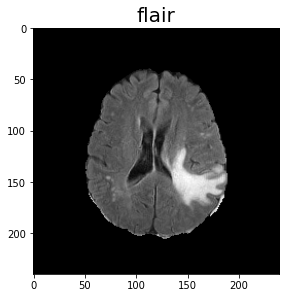

In [12]:
sample_image = io.imread(files[1], plugin="simpleitk")

print(f"shape: {sample_image.shape}")

fig = plt.figure(figsize=(15,10))

axis1 = fig.add_subplot(1,3,1)
axis1.imshow(sample_image[90,:,:],cmap='gray')
plt.title("flair", fontsize=20)


the images are converted into array. standarization and image resize is perfomed.

In [13]:
def to_array(path, end):
    files = glob(path+end, recursive=True)
    
    image_list = []
    
    r.seed(42)
    r.shuffle(files)
    
    for file in files:
        img = io.imread(file, plugin="simpleitk")

        
        img = (img-img.mean())/img.std()
        img.astype("float32")
        
        for slice in range(60, 130):
            image_slice = img[slice,:,:]
            
            
            image_slice = cv2.resize(image_slice, (128,128))
            
            image_slice = np.expand_dims(image_slice, axis=0)
            image_list.append(image_slice)
            
    return np.array(image_list,np.float32)

In [14]:
first_img = io.imread(files[1], plugin="simpleitk")

print(f"shape: {first_img.shape}")




shape: (155, 240, 240)


In [15]:
first_img.shape

exp = first_img[60,:,:]

exp.shape

(240, 240)

to add channel to the shape of the data as a 3D needs width,height and channel.

In [16]:
exp = np.expand_dims(exp, axis=0)

exp.shape

(1, 240, 240)

seg images are converted into array and the labels are used to identify the tumor area.

In [17]:
def seg_to_array(path, end, label):
    
    
    files = glob(path+end, recursive=True)
    
    image_list = []
    
    r.seed(42)
    r.shuffle(files)
    
    for file in files:
        image = io.imread(file, plugin="simpleitk")
        
        # all tumor
        if label == 1:
            image[image != 0] = 1
        
        # Non-enhancing Tumor
        if label == 2:
            image[image != 1] = 0
        
        # Without Edema
        if label == 3:
            image[image == 2] = 0
            image[image != 0] = 1
        
        # Enhancing Tumor
        if label == 4:
            image[image != 4] = 0
            image[image == 4] = 1
            

        image.astype("float32")
        
        for slice in range(60, 130):
            image_slice = image[slice,:,:]
            
            
            image_slice = cv2.resize(image_slice, (128,128))
            
            image_slice = np.expand_dims(image_slice, axis=0)
            image_list.append(image_slice)
            
    return np.array(image_list,np.float32)

In [18]:
seg_all_tumor = seg_to_array(path=path, end="**/*seg.nii.gz", label=1)

seg_non_enhancing = seg_to_array(path=path, end="**/*seg.nii.gz", label=2)

seg_out_edema = seg_to_array(path=path, end="**/*seg.nii.gz", label=3) 

seg_enhancing = seg_to_array(path=path, end="**/*seg.nii.gz", label=4) 

seg_original = seg_to_array(path=path, end="**/*seg.nii.gz", label=0)

converting all flair and t2 images into array .

In [19]:
flair = to_array(path=path, end="**/*flair.nii.gz")
t2 = to_array(path=path, end="**/*t2.nii.gz")
seg = seg_to_array(path=path, end="**/*seg.nii.gz", label=1)

combining the two images as one and printing their shapes.

In [24]:
X_train = np.concatenate((flair, t2), axis=1)
X_train.shape

(2240, 2, 128, 128)

to check accuracy in unet model dice coefficient is used, it gives us the difference of pixel. when we put images on top of each other and when the input and output are images the difference of pixels is needed.

In [25]:
def dice_coef(y_true, y_pred):
    smooth = 0.005 
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)
    

K.set_image_data_format('channels_first')

unet model is defined.

In [26]:
def unet():
    
    inputs = Input((2, 128 , 128))
    
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same') (inputs)
    batch1 = BatchNormalization(axis=1)(conv1)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same') (batch1)
    batch1 = BatchNormalization(axis=1)(conv1)
    pool1 = MaxPooling2D((2, 2))(batch1)
    
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same') (pool1)
    batch2 = BatchNormalization(axis=1)(conv2)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same') (batch2)
    batch2 = BatchNormalization(axis=1)(conv2)
    pool2 = MaxPooling2D((2, 2))(batch2)
    
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same') (pool2)
    batch3 = BatchNormalization(axis=1)(conv3)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same') (batch3)
    batch3 = BatchNormalization(axis=1)(conv3)
    pool3 = MaxPooling2D((2, 2))(batch3)
    
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same') (pool3)
    batch4 = BatchNormalization(axis=1)(conv4)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same') (batch4)
    batch4 = BatchNormalization(axis=1)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(batch4)
    
    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same') (pool4)
    batch5 = BatchNormalization(axis=1)(conv5)
    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same') (batch5)
    batch5 = BatchNormalization(axis=1)(conv5)
    
    up6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same') (batch5)
    up6 = concatenate([up6, conv4], axis=1)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same') (up6)
    batch6 = BatchNormalization(axis=1)(conv6)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same') (batch6)
    batch6 = BatchNormalization(axis=1)(conv6)
    
    up7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same') (batch6)
    up7 = concatenate([up7, conv3], axis=1)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same') (up7)
    batch7 = BatchNormalization(axis=1)(conv7)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same') (batch7)
    batch7 = BatchNormalization(axis=1)(conv7)
    
    up8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (batch7)
    up8 = concatenate([up8, conv2], axis=1)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same') (up8)
    batch8 = BatchNormalization(axis=1)(conv8)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same') (batch8)
    batch8 = BatchNormalization(axis=1)(conv8)
    
    up9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (batch8)
    up9 = concatenate([up9, conv1], axis=1)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same') (up9)
    batch9 = BatchNormalization(axis=1)(conv9)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same') (batch9)
    batch9 = BatchNormalization(axis=1)(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(batch9)

    model = Model(inputs=[inputs], outputs=[conv10])

    model.compile(optimizer=Adam(lr=1e-4), loss=dice_coef_loss, metrics=[dice_coef])

    return model

summary of the model

In [59]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2, 128, 128) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 128, 128) 1216        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 64, 128, 128) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 128, 128) 36928       batch_normalization[0][0]        
______________________________________________________________________________________________

In [27]:
model = unet()

the model is trained for 30 epoch.

In [28]:
model.fit(X_train, seg, validation_split=0.25, batch_size=32, epochs=30, shuffle=True)

Epoch 1/30
53/53 [==============================] - 72s 539ms/step - loss: 0.8834 - dice_coef: 0.1166 - val_loss: 0.9567 - val_dice_coef: 0.0421
Epoch 2/30
53/53 [==============================] - 23s 431ms/step - loss: 0.8047 - dice_coef: 0.1953 - val_loss: 0.9351 - val_dice_coef: 0.0631
Epoch 3/30
53/53 [==============================] - 24s 452ms/step - loss: 0.7412 - dice_coef: 0.2588 - val_loss: 0.9283 - val_dice_coef: 0.0697
Epoch 4/30
53/53 [==============================] - 24s 457ms/step - loss: 0.7134 - dice_coef: 0.2866 - val_loss: 0.9238 - val_dice_coef: 0.0741
Epoch 5/30
53/53 [==============================] - 23s 444ms/step - loss: 0.6842 - dice_coef: 0.3158 - val_loss: 0.9339 - val_dice_coef: 0.0642
Epoch 6/30
53/53 [==============================] - 23s 443ms/step - loss: 0.6411 - dice_coef: 0.3589 - val_loss: 0.9224 - val_dice_coef: 0.0754
Epoch 7/30
53/53 [==============================] - 24s 446ms/step - loss: 0.6301 - dice_coef: 0.3699 - val_loss: 0.9266 - val_dic

In [31]:
x = np.zeros((1,2,128,128),np.float32)
x[:,:1,:,:] = flair[89:90,:,:,:]   
x[:,1:,:,:] = t2[89:90,:,:,:] 

pred_full = model.predict(x)

the input is passed and predicted , the images are plotted.

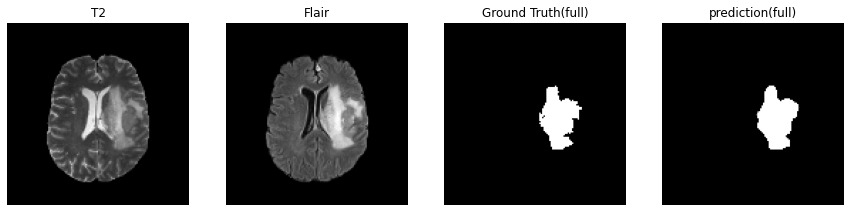

In [33]:

plt.figure(figsize=(15,10))

plt.subplot(141)
plt.title('T2')
plt.axis('off')
plt.imshow(t2[90, 0, :, :],cmap='gray')
    
plt.subplot(142)
plt.title('Flair')
plt.axis('off')
plt.imshow(flair[90, 0, :, :],cmap='gray')

plt.subplot(143)
plt.title('Ground Truth(full)')
plt.axis('off')
plt.imshow(seg[90, 0, :, :],cmap='gray')

plt.subplot(144)
plt.title('prediction(full)')
plt.axis('off')
plt.imshow(pred_full[0, 0, :, :],cmap='gray')

plt.show()

the model is saved.

In [34]:
model.save_weights("/content/drive/MyDrive/Brats/subset_model.h5")

In [35]:
def crop_tumor_tissue(x, pred, size):   
    crop_x = []
    list_xy = []
    p_tmp = pred[0,:,:]
    p_tmp[p_tmp>0.2] = 1    
    p_tmp[p_tmp !=1] = 0
    
    index_xy = np.where(p_tmp==1)   

    if index_xy[0].shape[0] == 0:   
        return [],[]  
    center_x = (max(index_xy[0]) + min(index_xy[0])) / 2 
    center_y = (max(index_xy[1]) + min(index_xy[1])) / 2 
    
    if center_x >= 176:
            center_x = center_x-8   
    length = max(index_xy[0]) - min(index_xy[0])
    width = max(index_xy[1]) - min(index_xy[1])
        
    if width <= 64 and length <= 64:  
        img_x = np.zeros((1,size,size),np.float32)
        img_x[:,:,:] = x[:,int(center_x - size/2) : int(center_x + size/2),int(center_y - size/2) : int(center_y + size/2)]
        crop_x.append(img_x) 
        list_xy.append((int(center_x - size/2),int(center_y - size/2)))
            
    if width > 64 and length <= 64:  
        img_x = np.zeros((1,size,size),np.float32)
        img_x[:,:,:] = x[:,int(center_x - size/2) : int(center_x + size/2),int(center_y - size) : int(center_y)]
        crop_x.append(img_x)
        list_xy.append((int(center_x - size/2),int(center_y - size)))
            
        img_x = np.zeros((1,size,size),np.float32)
        img_x[:,:,:] = x[:,int(center_x - size/2) : int(center_x + size/2),int(center_y + 1) : int(center_y + size + 1)]
        crop_x.append(img_x)
        list_xy.append((int(center_x - size/2),int(center_y)))
            
    if width <= 64 and length > 64:         
        img_x = np.zeros((1,size,size),np.float32)
        img_x[:,:,:] = x[:,int(center_x - size) : int(center_x),int(center_y - size/2) : int(center_y + size/2)]
        crop_x.append(img_x)
        list_xy.append((int(center_x - size),int(center_y - size/2)))
            
        img_x = np.zeros((1,size,size),np.float32)
        img_x[:,:,:] = x[:,int(center_x + 1) : int(center_x + size + 1),int(center_y - size/2) : int(center_y + size/2)]
        crop_x.append(img_x)
        list_xy.append((int(center_x),int(center_y - size/2)))
            
    if width > 64 and length > 64:  
        img_x = np.zeros((1,size,size),np.float32)
        img_x[:,:,:] = x[:,int(center_x - size) : int(center_x),int(center_y - size) : int(center_y)]
        crop_x.append(img_x)
        list_xy.append((int(center_x - size),int(center_y - size)))
            
        img_x = np.zeros((1,size,size),np.float32)
        img_x[:,:,:] = x[:,int(center_x + 1) : int(center_x + size + 1),int(center_y - size) : int(center_y)]
        crop_x.append(img_x)
        list_xy.append((int(center_x),int(center_y - size)))
            
        img_x = np.zeros((1,size,size),np.float32)
        img_x[:,:,:] = x[:,int(center_x - size) : int(center_x),int(center_y + 1) : int(center_y + size + 1)]
        crop_x.append(img_x)
        list_xy.append((int(center_x - size),int(center_y)))
            
        img_x = np.zeros((1,size,size),np.float32)
        img_x[:,:,:] = x[:,int(center_x + 1) : int(center_x + size + 1),int(center_y + 1) : int(center_y + size + 1)]
        crop_x.append(img_x)
        list_xy.append((int(center_x),int(center_y)))
        
    
        
    return np.array(crop_x) , list_xy   

In [39]:
t1ce = to_array(path=path, end="**/*t1ce.nii.gz")
t1 = to_array(path=path, end="**/*t1.nii.gz")

In [ ]:
the t1ce image is passed as an input and the image is cropped as per the center point of full tumor segmentation.

In [40]:
crop , li = crop_tumor_tissue(t1ce[90,:,:,:],pred_full[0,:,:,:],64)

In [41]:
crop.shape[0]

1

another u net is defined

In [43]:
def unet_1():
    
    inputs = Input((1, 64 , 64))
    
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same') (inputs)
    batch1 = BatchNormalization(axis=1)(conv1)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same') (batch1)
    batch1 = BatchNormalization(axis=1)(conv1)
    pool1 = MaxPooling2D((2, 2))(batch1)
    
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same') (pool1)
    batch2 = BatchNormalization(axis=1)(conv2)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same') (batch2)
    batch2 = BatchNormalization(axis=1)(conv2)
    pool2 = MaxPooling2D((2, 2))(batch2)
    
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same') (pool2)
    batch3 = BatchNormalization(axis=1)(conv3)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same') (batch3)
    batch3 = BatchNormalization(axis=1)(conv3)
    pool3 = MaxPooling2D((2, 2))(batch3)
    
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same') (pool3)
    batch4 = BatchNormalization(axis=1)(conv4)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same') (batch4)
    batch4 = BatchNormalization(axis=1)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(batch4)
    
    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same') (pool4)
    batch5 = BatchNormalization(axis=1)(conv5)
    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same') (batch5)
    batch5 = BatchNormalization(axis=1)(conv5)
    
    up6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same') (batch5)
    up6 = concatenate([up6, conv4], axis=1)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same') (up6)
    batch6 = BatchNormalization(axis=1)(conv6)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same') (batch6)
    batch6 = BatchNormalization(axis=1)(conv6)
    
    up7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same') (batch6)
    up7 = concatenate([up7, conv3], axis=1)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same') (up7)
    batch7 = BatchNormalization(axis=1)(conv7)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same') (batch7)
    batch7 = BatchNormalization(axis=1)(conv7)
    
    up8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (batch7)
    up8 = concatenate([up8, conv2], axis=1)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same') (up8)
    batch8 = BatchNormalization(axis=1)(conv8)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same') (batch8)
    batch8 = BatchNormalization(axis=1)(conv8)
    
    up9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (batch8)
    up9 = concatenate([up9, conv1], axis=1)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same') (up9)
    batch9 = BatchNormalization(axis=1)(conv9)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same') (batch9)
    batch9 = BatchNormalization(axis=1)(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(batch9)

    model = Model(inputs=[inputs], outputs=[conv10])

    model.compile(optimizer=Adam(lr=1e-4), loss=dice_coef_loss, metrics=[dice_coef])

    return model

In [45]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2, 128, 128) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 128, 128) 1216        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 64, 128, 128) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 128, 128) 36928       batch_normalization[0][0]        
______________________________________________________________________________________________

In [46]:

model_core = unet_1()
model_ET = unet_1()

In [47]:
pred_core = model_core.predict(crop)
pred_ET = model_ET.predict(crop)

In [55]:
def paint_color_algo(pred_full, pred_core , pred_ET , li):   
    
    pred_full[pred_full > 0.2] = 2    
    pred_full[pred_full != 2] = 0
    pred_core[pred_core > 0.2] = 1      
    pred_core[pred_core != 1] = 0
    pred_ET[pred_ET > 0.2] = 4          
    pred_ET[pred_ET != 4] = 0

    total = np.zeros((1,128,128),np.float32)  
    total[:,:,:] = pred_full[:,:,:]
    for i in range(pred_core.shape[0]):
        for j in range(64):
            for k in range(64):
                if pred_core[i,0,j,k] != 0 and pred_full[0,li[i][0]+j,li[i][1]+k] !=0:
                    total[0,li[i][0]+j,li[i][1]+k] = pred_core[i,0,j,k]
                if pred_ET[i,0,j,k] != 0 and pred_full[0,li[i][0]+j,li[i][1]+k] !=0:
                    total[0,li[i][0]+j,li[i][1]+k] = pred_ET[i,0,j,k]
                
    
    
    return total

In [56]:
tmp = paint_color_algo(pred_full[0,:,:,:], pred_core, pred_ET, li)

core = np.zeros((1,128,128),np.float32)
ET = np.zeros((1,128,128),np.float32)
core[:,:,:] = tmp[:,:,:]
ET[:,:,:] = tmp[:,:,:]
core[core == 4] = 1
core[core != 1] = 0
ET[ET != 4] = 0

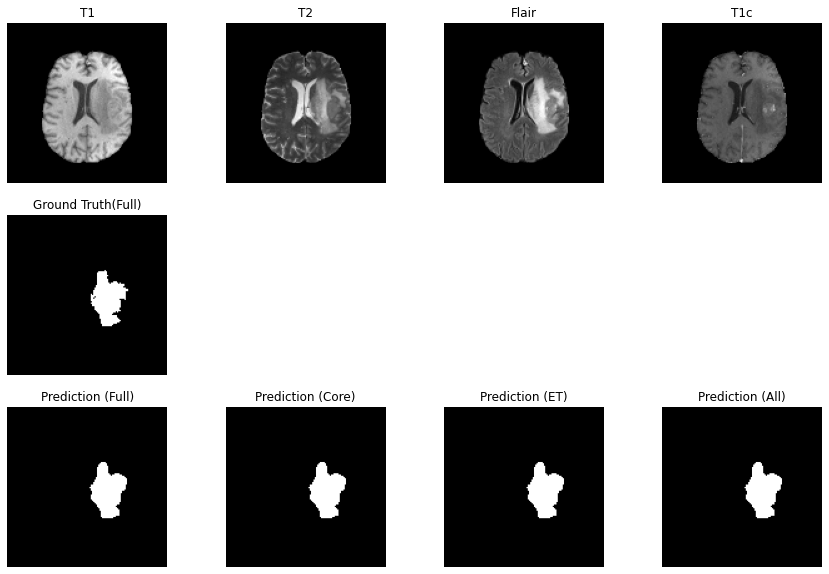

In [58]:
plt.figure(figsize=(15,10))

plt.subplot(341)
plt.title('T1')
plt.axis('off')
plt.imshow(t1[90, 0, :, :],cmap='gray')

plt.subplot(342)
plt.title('T2')
plt.axis('off')
plt.imshow(t2[90, 0, :, :],cmap='gray')
    
plt.subplot(343)
plt.title('Flair')
plt.axis('off')
plt.imshow(flair[90, 0, :, :],cmap='gray')

plt.subplot(344)
plt.title('T1c')
plt.axis('off')
plt.imshow(t1ce[90, 0, :, :],cmap='gray')

plt.subplot(345)
plt.title('Ground Truth(Full)')
plt.axis('off')
plt.imshow(seg[90, 0, :, :],cmap='gray')


plt.subplot(349)
plt.title('Prediction (Full)')
plt.axis('off')
plt.imshow(pred_full[0, 0, :, :],cmap='gray')

plt.subplot(3,4,10)
plt.title('Prediction (Core)')
plt.axis('off')
plt.imshow(core[0, :, :],cmap='gray')

plt.subplot(3,4,11)
plt.title('Prediction (ET)')
plt.axis('off')
plt.imshow(ET[0, :, :],cmap='gray')

plt.subplot(3,4,12)
plt.title('Prediction (All)')
plt.axis('off')
plt.imshow(tmp[0, :, :],cmap='gray')

plt.show()
